This notebook will now have 

1. Regression of Behavior + GCamp 




In [1]:
import numpy as np 
import pandas as pd
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec


import seaborn as sns
import os



# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)



In [2]:
%load_ext rpy2.ipython
%R library(lme4)
%R library(parallel)
%R library(lmerTest)
%R library(pbkrtest)
# %R library(MuMIn, quiet = True)

/anaconda/envs/biomath2/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/anaconda/envs/biomath2/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘lmerTest’


  warnings.warn(x, RRuntimeWarning)
/anaconda/envs/biomath2/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:lme4’:

    lmer


  warnings.warn(x, RRuntimeWarning)
/anaconda/envs/biomath2/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:stats’:

    step


  warnings.warn(x, RRuntimeWarning)


array(['pbkrtest', 'lmerTest', 'parallel', 'lme4', 'Matrix', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], 
      dtype='<U9')

In [3]:
%load_ext jupyternotify

%autonotify -a 30

<IPython.core.display.Javascript object>

In [4]:
%%R
f_lmer_mc = function(data, calls, mc.cores) {
    require(parallel)
    if (is.data.frame(data)) 
        data = replicate(length(calls), data, simplify = F)
    for (i in 1:length(data)) attr(data[[i]], "cll") = calls[i]
    m.list = mclapply(data, function(i) eval(parse(text = attr(i, "cll"))), 
        mc.cores = mc.cores)
    return(m.list)
}

In [5]:
%%time
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp.csv", index_col = 0) # .dropna(subset=['Q_dir_diff'])


df_trials = pd.read_csv("data/int_pc_qvals.csv", index_col = 0)


# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all

df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



CPU times: user 1.51 s, sys: 59.1 ms, total: 1.57 s
Wall time: 6.35 s


In [6]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2
GCAMP_RANGE = np.arange(-1, 2, 1/dt)

# for trials in general 

NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

In [96]:
# df_corr = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS'])
df_corr = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'NaC']).reset_index()

In [97]:
# normalize

def normalize(x, mu, std):
    return (x - mu) / std


for mouse_id in np.unique(df_corr['MouseID']):
    
    mice_q = np.copy(df_corr.loc[df_corr['MouseID'] == mouse_id, 'Q_dir_diff'].values)
    mice_mu = (np.mean(mice_q[~np.isnan(mice_q)]))
    mice_std = (np.std(mice_q[~np.isnan(mice_q)]))

    df_corr.loc[df_corr['MouseID'] == mouse_id, 'Q_dir_diff'] = normalize(mice_q, mice_mu, mice_std)

    

# regression with all timepoints

In [98]:
df_corr_r = df_corr.drop(['g_np', 'g_lp', 'g_choice', 'g_reward', 'Stay/Leave'], axis = 1)
gcamp_temp = pd.DataFrame(list(df_corr.g_lp.values)) #update 

In [99]:
df_corr_g_r = df_corr_r.join(gcamp_temp)
df_corr_g_r = df_corr_g_r.dropna()

In [100]:
%%R -i df_corr_g_r
# print(df_corr_g_r['X0'])


NULL


In [101]:
%%R 

models = c('lmer(X0~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X1~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X2~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X3~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X4~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X5~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X6~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X7~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X8~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X9~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X10~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X11~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X12~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X13~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X14~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)')
# rmodels = c('lmer(X0~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X1~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X2~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X3~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X4~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X5~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X6~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X7~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X8~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X9~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X10~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X11~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X12~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X13~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X14~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)')
np_i = f_lmer_mc(df_corr_g_r, models, 15)
m = np_i

print('One third done')
models2 = c('lmer(X15~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X16~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X17~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X18~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X19~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X20~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X21~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X22~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X23~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X24~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X25~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X26~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X27~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X28~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X29~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)')
# rmodels2 = c('lmer(X15~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X16~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X17~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X18~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X19~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X20~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X21~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X22~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X23~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X24~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X25~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X26~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X27~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X28~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X29~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)')
np_i = f_lmer_mc(df_corr_g_r, models2, 15)
m = c(m, np_i)

print('two third done')

models3 = c('lmer(X30~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X31~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X32~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X33~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X34~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X35~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X36~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X37~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X38~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X39~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X40~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X41~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X42~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X43~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X44~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)')
# rmodels3 = c('lmer(X30~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X31~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X32~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X33~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X34~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X35~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X36~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X37~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X38~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X39~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X40~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X41~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X42~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X43~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)', 'lmer(X44~  Q_ch_diff * Action + Reward + (1 + Reward + Q_ch_diff * Action |MouseID), data = i)')
np_i = f_lmer_mc(df_corr_g_r, models3, 15)
m = c(m, np_i)


print('done')




[1] "One third done"
[1] "two third done"
[1] "done"


<IPython.core.display.Javascript object>

In [102]:
%%R -o df_all
for (i in seq(45)){
    df = as.data.frame(coef(summary(m[[i]])))

    if (ncol(df) == 3){
        df$'t value' = NA
        df$'Pr(>|t|)' = NA
        df$df = NA 
    }
    df$names = rownames(df)
    rownames(df) = NULL
    df$timelocked = 'LeverPrsnt' #update
    df$RecordLoc = 'NaC'    #update
    df$time = (i - 16)/15

                       
    if (i == 1) {
        df_all = df
    } else {
        df_all = rbind(df_all, df)
    }
}

/anaconda/envs/biomath2/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in calculation of the Satterthwaite's approximation. The output of lme4 package is returned

  warnings.warn(x, RRuntimeWarning)
/anaconda/envs/biomath2/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: summary from lme4 is returned
some computational error has occurred in lmerTest

  warnings.warn(x, RRuntimeWarning)


<IPython.core.display.Javascript object>

In [103]:
df_all.to_csv(os.path.join('data/NaC', 'dir_lever_m.csv')) #update

In [52]:
%R print(summary(m[[1]]))

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: X0 ~ Q_ch_diff * Action + (1 + Q_ch_diff * Action | MouseID)
   Data: i

REML criterion at convergence: 17343

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9802 -0.6173 -0.1226  0.4662  5.6948 

Random effects:
 Groups   Name                Variance Std.Dev. Corr             
 MouseID  (Intercept)         0.042151 0.20531                   
          Q_ch_diff           0.009591 0.09794   0.63            
          ActionIps           0.037132 0.19270  -0.89 -0.53      
          Q_ch_diff:ActionIps 0.013212 0.11494  -0.23 -0.90  0.12
 Residual                     0.551361 0.74254                   
Number of obs: 7698, groups:  MouseID, 11

Fixed effects:
                    Estimate Std. Error       df t value Pr(>|t|)   
(Intercept)         -0.23186    0.06338 10.03600  -3.658  0.00438 **
Q_ch_diff           -0.04664    0.03694  8.36700  -1.262  0.2408

In [ ]:
%%R -o df_all
df_all$timelocked = 'Reward'

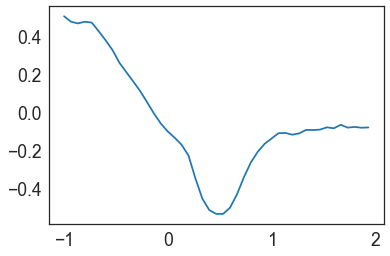

In [20]:
plt.plot(np.unique(df_all['time']), df_all[df_all['names'] == '(Intercept)'].Estimate)

In [ ]:
%R reward_m[[2]]

In [ ]:
%%R
if(requireNamespace("pbkrtest", quietly = TRUE))
    print(summary(reward_m[[15]], ddf="Kenward-Roger"))

In [ ]:
%R print(coef(reward_m[[15]], ddf="Kenward-Roger"))

In [ ]:
import pickle 
# mm = [nosepoke_m, leverpress_m, choice_m, reward_m]
pickle.dump(mm, open( "data/mm_reg_all_DMS.p", "wb" ) )

In [61]:
models = []
for i in np.arange(45):
    models.append('lmer(X' + str(i) + '~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)')
    
print(models[:15])
    

['lmer(X0~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X1~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X2~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X3~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X4~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X5~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X6~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X7~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X8~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X9~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X10~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X11~  Q_dir_diff * Action + (1 + Q_dir_diff * Action |MouseID), data = i)', 'lmer(X12~  Q_dir_diff * 

# Analyzing Regression in real time

In [ ]:
import pickle
mm_reg = pickle.load( open( "data/mm_reg_all_DMS.p", "rb" ) )

In [ ]:
nosepoke_m = mm_reg[0]
leverprsnt_m = mm_reg[1]
choice_m = mm_reg[2]
reward_m = mm_reg[3]
%R -i nosepoke_m,leverprsnt_m,choice_m,reward_m

In [ ]:
%R print(summary(nosepoke_m[[2]]))

In [ ]:
df = pd.read_csv('data/mm_reg_vals.csv')

In [ ]:
plt.figure(figsize = (12, 4))
ax = plt.gca()
sns.barplot(data = df, x = 'timelocked', y = 'Estimate', hue = 'names')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.errorbar(x=np.delete(np.arange(-0.3, 3.4, 0.2), [4, 9, 14]), y=df.Estimate, yerr=df['Std. Error'], fmt = 'None', elinewidth = 2, ecolor = 'k')


In [ ]:
df

# First Pass Regression



**Regression to compute** 

avg_i ~  Q * Action + (1 + Q * Action |MouseID)

avg_i averages over 0 - 1.0 seconds with i = nosepoke, leverpresentation, choice, reward

Q = Q_chosen, Q_ch_diff, Q_dir_diff





In [ ]:
df_corr_r = df_corr.drop(['g_np', 'g_lp', 'g_choice', 'g_reward', 'Stay/Leave'], axis = 1)
df_corr_r = df_corr_r.dropna()

In [ ]:
%%R -i df_corr_r
print(head(df_corr_r))


In [ ]:
%%R -o nosepoke_m,leverprsnt_m

models = c("lmer(avg_np ~  Q_chosen * Action + (1 + Q_chosen * Action |MouseID), data = i)",
           "lmer(avg_np ~  Q_ch_diff * Action + (1 + Q_ch_diff * Action |MouseID), data = i)",
          "lmer(avg_np ~  Q_dir_diff * Action + (1 +  Q_dir_diff * Action|MouseID), data = i)")
np.list = f_lmer_mc(df_corr_r, models, 3)

nosepoke_m = np.list

models = c("lmer(avg_lp ~  Q_chosen * Action + (1 + Q_chosen * Action |MouseID), data = i)",
           "lmer(avg_lp ~  Q_ch_diff * Action + (1 + Q_ch_diff * Action |MouseID), data = i)",
          "lmer(avg_lp ~  Q_dir_diff * Action + (1 +  Q_dir_diff * Action|MouseID), data = i)")
lp.list = f_lmer_mc(df_corr_r, models, 3)

leverprsnt_m = lp.list


In [ ]:
%%R -o choice_m

models = c("lmer(avg_ch ~  Q_chosen * Action + (1 + Q_chosen * Action |MouseID), data = i)",
           "lmer(avg_ch ~  Q_ch_diff * Action + (1 + Q_ch_diff * Action |MouseID), data = i)",
          "lmer(avg_ch ~  Q_dir_diff * Action + (1 +  Q_dir_diff * Action|MouseID), data = i)")
m.list = f_lmer_mc(df_corr_r, models, 3)

choice_m = m.list

models = c("lmer(avg_r ~  Q_chosen * Action + (1 + Q_chosen * Action |MouseID), data = i)",
           "lmer(avg_r ~  Q_ch_diff * Action + (1 + Q_ch_diff * Action |MouseID), data = i)",
          "lmer(avg_r ~  Q_dir_diff * Action + (1 +  Q_dir_diff * Action|MouseID), data = i)")
m.list = f_lmer_mc(df_corr_r, models, 3)

reward_m = m.list


In [ ]:
import pickle 
mm = [nosepoke_m, leverprsnt_m, choice_m, reward_m]
pickle.dump(mm, open( "data/mm_reg.p", "wb" ) )

In [ ]:
%R print(r.squaredGLMM(nosepoke_m[[1]]))
%R print(r.squaredGLMM(nosepoke_m[[2]]))
%R print(r.squaredGLMM(nosepoke_m[[3]]))


In [ ]:
%%R
Q_type = 2
df = as.data.frame(coef(summary(nosepoke_m[[Q_type]])))
df$names = rownames(df)
rownames(df) = NULL
df$timelocked = 'Nosepoke'




In [ ]:
%R mm[1][[1]]

In [ ]:
%%R -o
to_add <- c(leverprsnt_m[[Q_type]], choice_m[[Q_type]], reward_m[[Q_type]])
tl = c('LeverPress', 'Choice', 'Reward')
i = 0
for (mm_i in to_add){
    i = i + 1
    df_temp = as.data.frame(coef(summary(mm_i)))
    df_temp$names = rownames(df_temp)
    rownames(df_temp) = NULL
    df_temp$timelocked = tl[i]
    df = rbind(df, df_temp)
}



In [ ]:
%R print(summary(reward_m[[1]]))

# Diagnostics Scripts

In [ ]:
%time %R print(summary(lmer('avg_lp ~  Q_chosen * Action + (1 + Q_chosen * Action |MouseID)', data=df_corr_r)))


In [ ]:
# test_data = sm.datasets.get_rdataset('dietox', 'geepack').data

# Simplest Regression 
formula = 'avg_lp ~  Q_chosen'
lm = ols(formula, data = df_corr).fit()
lm.summary()

formula = 'avg_lp ~  Q_chosen * Action' # with interaction



In [ ]:
plt.plot(lm.resid)

In [ ]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(lm, ax = ax)

In [ ]:
influence = lm.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")